In [615]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from datetime import date
from datetime import datetime

import seaborn as sn
import matplotlib.pyplot as plt

In [616]:
def transform_date(dataframe):
    today = date.today()
    days = []
    for value in dataframe["Open Date"].values:
        casting_date = datetime.strptime(value, "%m/%d/%Y").date()
        delta = today - casting_date
        day = delta.days
        days.append(day)

    dataframe["Open Date"] = pd.Series(days, name="Open Days")
    return dataframe

In [617]:
dataset = pd.read_csv('income-prediction/train.csv')
dataset.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [618]:
dataset['City Group'] = (dataset['City Group'] == 'Big Cities').astype(int)
dataset['Type'] = (dataset['Type'] == 'IL').astype(int)

dataset.drop(['City', 'Id'], axis=1, inplace=True)

dataset = transform_date(dataset)
dataset.head()

,Open Date,City Group,Type,P1,P2,P3,P4,P5,P6,P7,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,8536,1,1,4,5.0,4.0,4.0,2,2,5,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,5402,1,0,4,5.0,4.0,4.0,1,2,5,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,3552,0,1,2,4.0,2.0,5.0,2,3,5,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3953,0,1,6,4.5,6.0,6.0,4,4,10,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4952,0,1,3,4.0,3.0,4.0,2,2,5,...,3.0,5,1,3,2,3,4,3,3,4316715.0


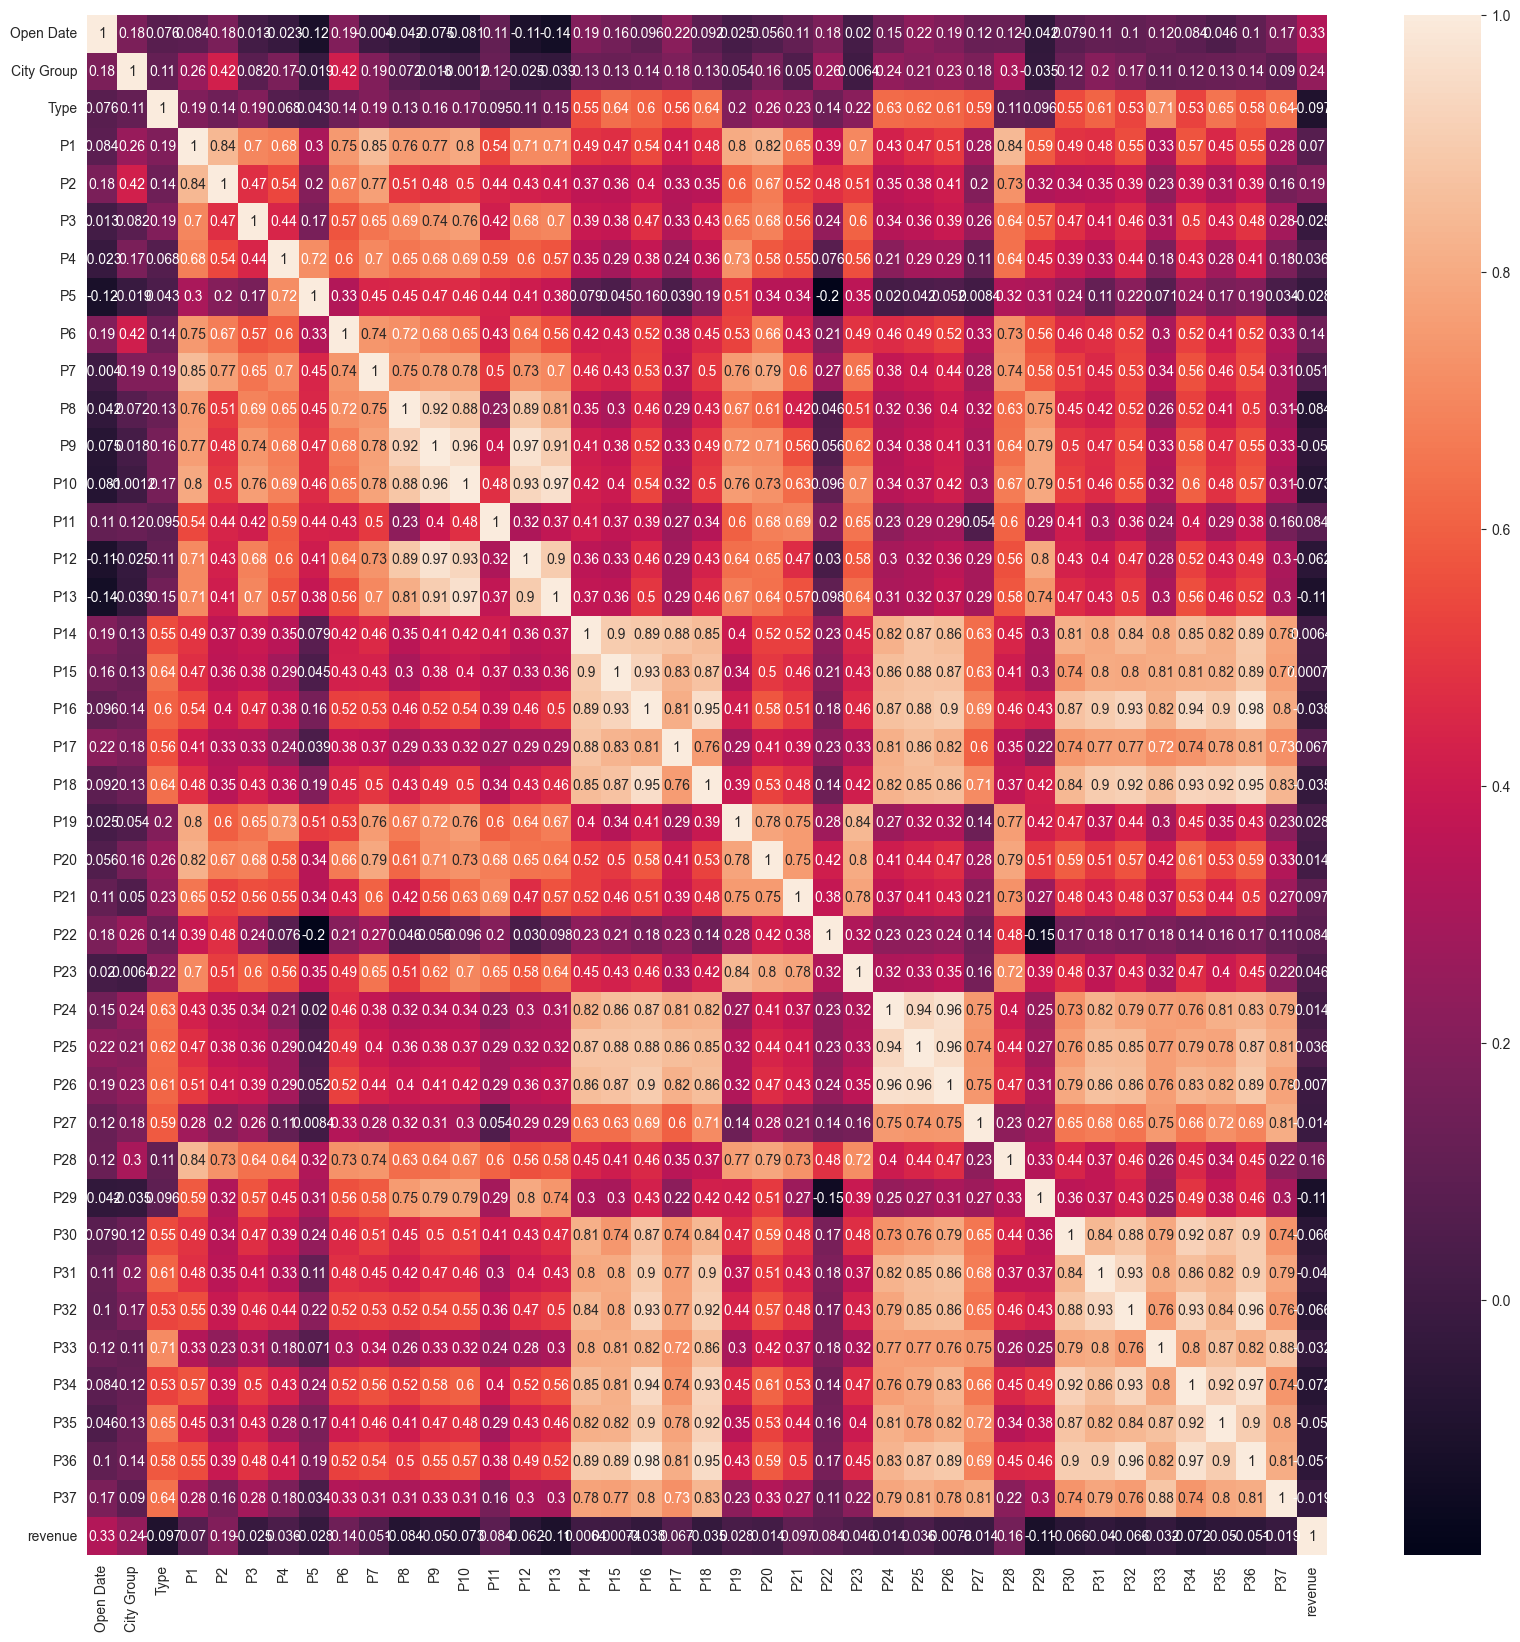

In [619]:
corr_matrix = dataset.corr()
plt.figure(figsize=(20, 20))
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [620]:
drop = []
for i in corr_matrix.columns.drop('revenue'):
    corr = corr_matrix[i].index
    for a in corr:
        if corr_matrix[i][a] > 0.9 and i != a:
            if corr_matrix['revenue'][i] > corr_matrix['revenue'][a]:
                drop.append(a) if a not in drop else 0
            else:
                drop.append(i) if i not in drop else 0

dataset.drop(drop, axis=1, inplace=True)

In [621]:
largest = corr_matrix['revenue'][np.abs(corr_matrix['revenue'] > 0.05)].index
largest = [i for i in largest if i not in drop]
dataset = dataset[largest]
dataset.head()

,Open Date,City Group,P1,P2,P6,P7,P11,P17,P21,P22,P28,revenue
0,8536,1,4,5.0,2,5,3,2,1,3,2.0,5653753.0
1,5402,1,4,5.0,2,5,1,0,1,3,3.0,6923131.0
2,3552,0,2,4.0,3,5,2,0,1,1,1.0,2055379.0
3,3953,0,6,4.5,4,10,8,3,6,1,2.5,2675511.0
4,4952,0,3,4.0,2,5,2,1,1,2,1.0,4316715.0


In [622]:
scale = MinMaxScaler()
for col in dataset.columns.drop(['revenue']):
    dataset[col] = scale.fit_transform(dataset[col].values.reshape(-1, 1))
dataset.head()

,Open Date,City Group,P1,P2,P6,P7,P11,P17,P21,P22,P28,revenue
0,0.819966,1.0,0.272727,0.615385,0.111111,0.444444,0.222222,0.133333,0.000000,0.50,0.086957,5653753.0
1,0.335651,1.0,0.272727,0.615385,0.111111,0.444444,0.000000,0.000000,0.000000,0.50,0.173913,6923131.0
2,0.049760,0.0,0.090909,0.461538,0.222222,0.444444,0.111111,0.000000,0.000000,0.00,0.000000,2055379.0
3,0.111729,0.0,0.454545,0.538462,0.333333,1.000000,0.777778,0.200000,0.357143,0.00,0.130435,2675511.0
4,0.266110,0.0,0.181818,0.461538,0.111111,0.444444,0.111111,0.066667,0.000000,0.25,0.000000,4316715.0


In [623]:
columns_len = dataset.columns.shape[0]

X = dataset.iloc[:, 0:columns_len - 1]
Y = dataset.iloc[:, columns_len - 1]

In [624]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=8)

X_test.reset_index(inplace=True)
y_test = pd.DataFrame(y_test.values)

X_test.drop('index', axis=1, inplace=True)

In [625]:
X_test.reset_index()

,index,Open Date,City Group,P1,P2,P6,P7,P11,P17,P21,P22,P28
0,0,0.316798,0.0,0.181818,0.307692,0.111111,0.111111,0.555556,0.000000,0.142857,0.00,0.130435
1,1,0.266110,0.0,0.181818,0.461538,0.111111,0.444444,0.111111,0.066667,0.000000,0.25,0.000000
2,2,0.427291,0.0,0.727273,0.769231,0.555556,1.000000,0.111111,0.000000,0.142857,0.50,0.565217
3,3,0.290682,0.0,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.00,0.000000
4,4,0.241385,1.0,0.272727,0.615385,0.222222,0.444444,0.111111,0.000000,0.071429,1.00,0.347826
5,5,0.042806,0.0,0.090909,0.307692,0.111111,0.444444,0.000000,0.000000,0.000000,0.25,0.086957
6,6,0.411219,1.0,0.000000,0.000000,0.000000,0.000000,0.444444,0.000000,0.000000,0.00,0.000000
7,7,0.101066,1.0,0.181818,0.461538,0.111111,0.444444,0.111111,0.000000,0.000000,0.50,0.086957
8,8,0.126565,0.0,0.181818,0.461538,0.000000,0.444444,0.111111,0.000000,0.000000,0.00,0.086957
9,9,0.360377,0.0,0.181818,0.461538,0.111111,0.444444,0.000000,0.000000,0.000000,0.25,0.173913


In [626]:
from sklearn.tree import DecisionTreeRegressor

In [627]:
DecisionTreeModel = DecisionTreeRegressor()
DecisionTreeModel = GridSearchCV(DecisionTreeModel, {
		"max_depth": [4, 6, 8]})

DecisionTreeModel.fit(X_train, y_train)

y_predict_test = DecisionTreeModel.predict(X_test)

print(f'DecisionTreeRegressor:\n'
      f'RMSE:\t{np.sqrt(mean_squared_error(y_test, y_predict_test))}')

DecisionTreeRegressor:
RMSE:	2163155.03176611


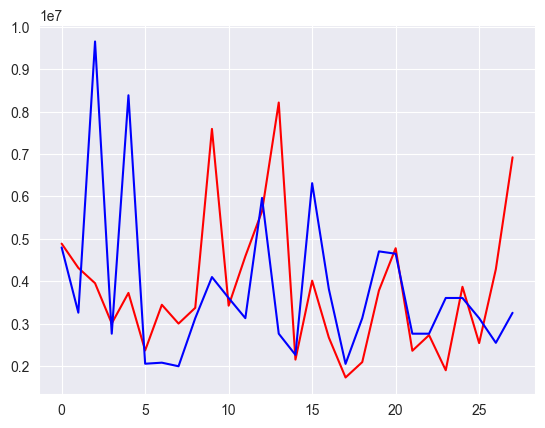

In [628]:
plt.plot(y_test, "red", y_predict_test, "blue")
plt.show()

In [629]:
from sklearn.ensemble import ExtraTreesRegressor

In [630]:
modelExtraTrees = ExtraTreesRegressor()
modelExtraTrees = GridSearchCV(modelExtraTrees, {
		"max_depth": [4, 6, 8],
        "n_estimators": [100, 500, 1000]})
modelExtraTrees.fit(X_train, y_train)

y_predict_test = modelExtraTrees.predict(X_test)

print(f'ExtraTreesRegressor:\n'
      f'RMSE:\t{np.sqrt(mean_squared_error(y_test, y_predict_test))}')

ExtraTreesRegressor:
RMSE:	1731173.1231721356


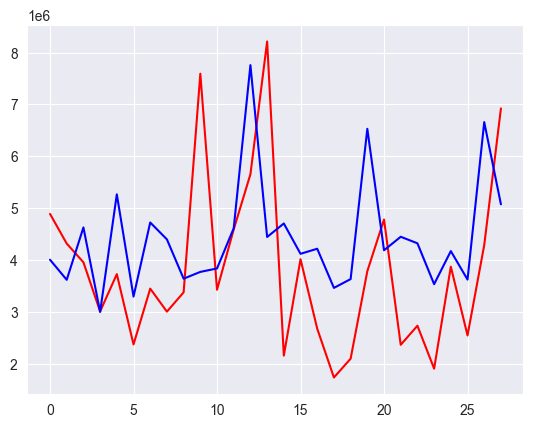

In [631]:
plt.plot(y_test, "red", y_predict_test, "blue")
plt.show()

In [632]:
from sklearn.ensemble import RandomForestRegressor

In [633]:
modelRandForest = RandomForestRegressor()

modelRandForest = GridSearchCV(modelRandForest, {
		"max_depth": [4, 6, 8],
        "n_estimators": [100, 500, 1000]})

modelRandForest.fit(X_train, y_train)

y_predict_test = modelRandForest.predict(X_test)

print(f'RandomForestRegressor:\n'
      f'RMSE:\t{np.sqrt(mean_squared_error(y_test, y_predict_test))}')

RandomForestRegressor:
RMSE:	1678953.7046704574


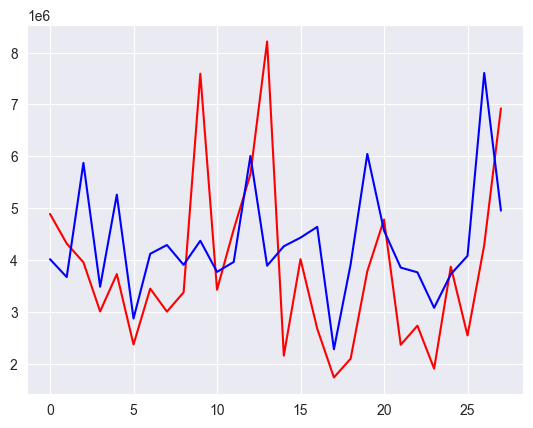

In [634]:
plt.plot(y_test, "red", y_predict_test, "blue")
plt.show()

In [635]:
from xgboost import XGBRegressor

In [636]:
modelXGBR = XGBRegressor()

modelXGBR = GridSearchCV(modelXGBR, {
		"max_depth": [4, 6, 8],
        "n_estimators": [100, 500, 1000]})

modelXGBR.fit(X_train, y_train)

y_predict_test = modelXGBR.predict(X_test)

print(f'XGBRegressor:\n'
      f'RMSE:\t{np.sqrt(mean_squared_error(y_test, y_predict_test))}')

XGBRegressor:
RMSE:	1705978.1781522015


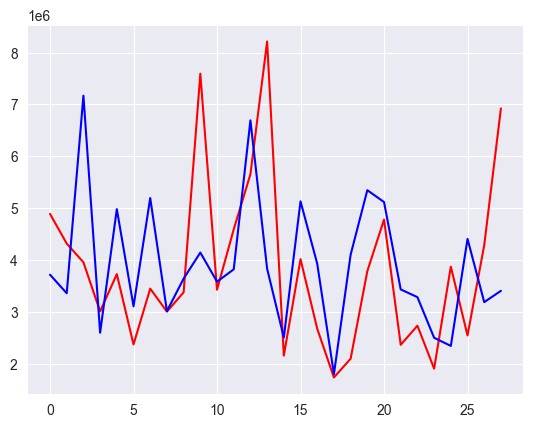

In [637]:
plt.plot(y_test, "red", y_predict_test, "blue")
plt.show()

In [638]:
from sklearn.ensemble import BaggingRegressor

In [639]:
modelCustomBagging = BaggingRegressor(XGBRegressor(n_estimators=1000),
                                      max_samples=0.5, max_features=0.5)

modelCustomBagging.fit(X_train, y_train)

y_predict_test = modelCustomBagging.predict(X_test)

print(f'BaggingRegressor, XGBRegressor:\n'
      f'RMSE:\t{np.sqrt(mean_squared_error(y_test, y_predict_test))}')

BaggingRegressor, XGBRegressor:
RMSE:	1695552.2847170092


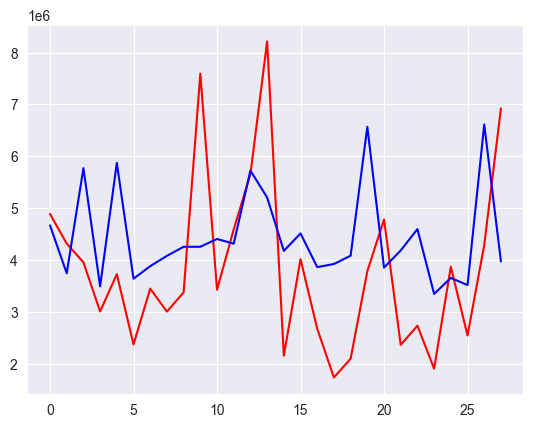

In [640]:
plt.plot(y_test, "red", y_predict_test, "blue")
plt.show()

In [641]:
from sklearn.ensemble import VotingRegressor

In [642]:
estimators = [('ExtraTrees', modelExtraTrees),
              ('RandomForest', modelRandForest),
              ('XGB', modelXGBR),
              ('DecisionTree', DecisionTreeModel),]

ensemble = VotingRegressor(estimators)

ensemble.fit(X_train, y_train)

y_predict_test = ensemble.predict(X_test)

print(f'VotingRegressor: ExtraTrees, RandomForest, XGB, ExtraTree, DecisionTree:\n'
      f'RMSE:\t{np.sqrt(mean_squared_error(y_test, y_predict_test))}')

VotingRegressor: ExtraTrees, RandomForest, XGB, ExtraTree, DecisionTree:
RMSE:	1581077.400940232


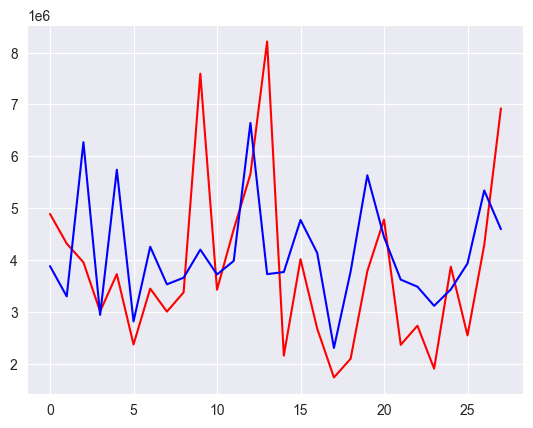

In [643]:
plt.plot(y_test, "red", y_predict_test, "blue")
plt.show()

In [644]:
estimators = [('ExtraTrees', modelExtraTrees),
              ('RandomForest', modelRandForest),
              ('XGB', modelXGBR),
              ('DecisionTree', DecisionTreeModel),]

ensemble = VotingRegressor(estimators)

ensemble.fit(X, Y)

y_predict= ensemble.predict(X)

print(f'VotingRegressor in all data: ExtraTrees, RandomForest, XGB, ExtraTree, DecisionTree:\n'
      f'RMSE:\t{np.sqrt(mean_squared_error(Y, y_predict))}')

VotingRegressor in all data: ExtraTrees, RandomForest, XGB, ExtraTree, DecisionTree:
RMSE:	1245656.8829494615


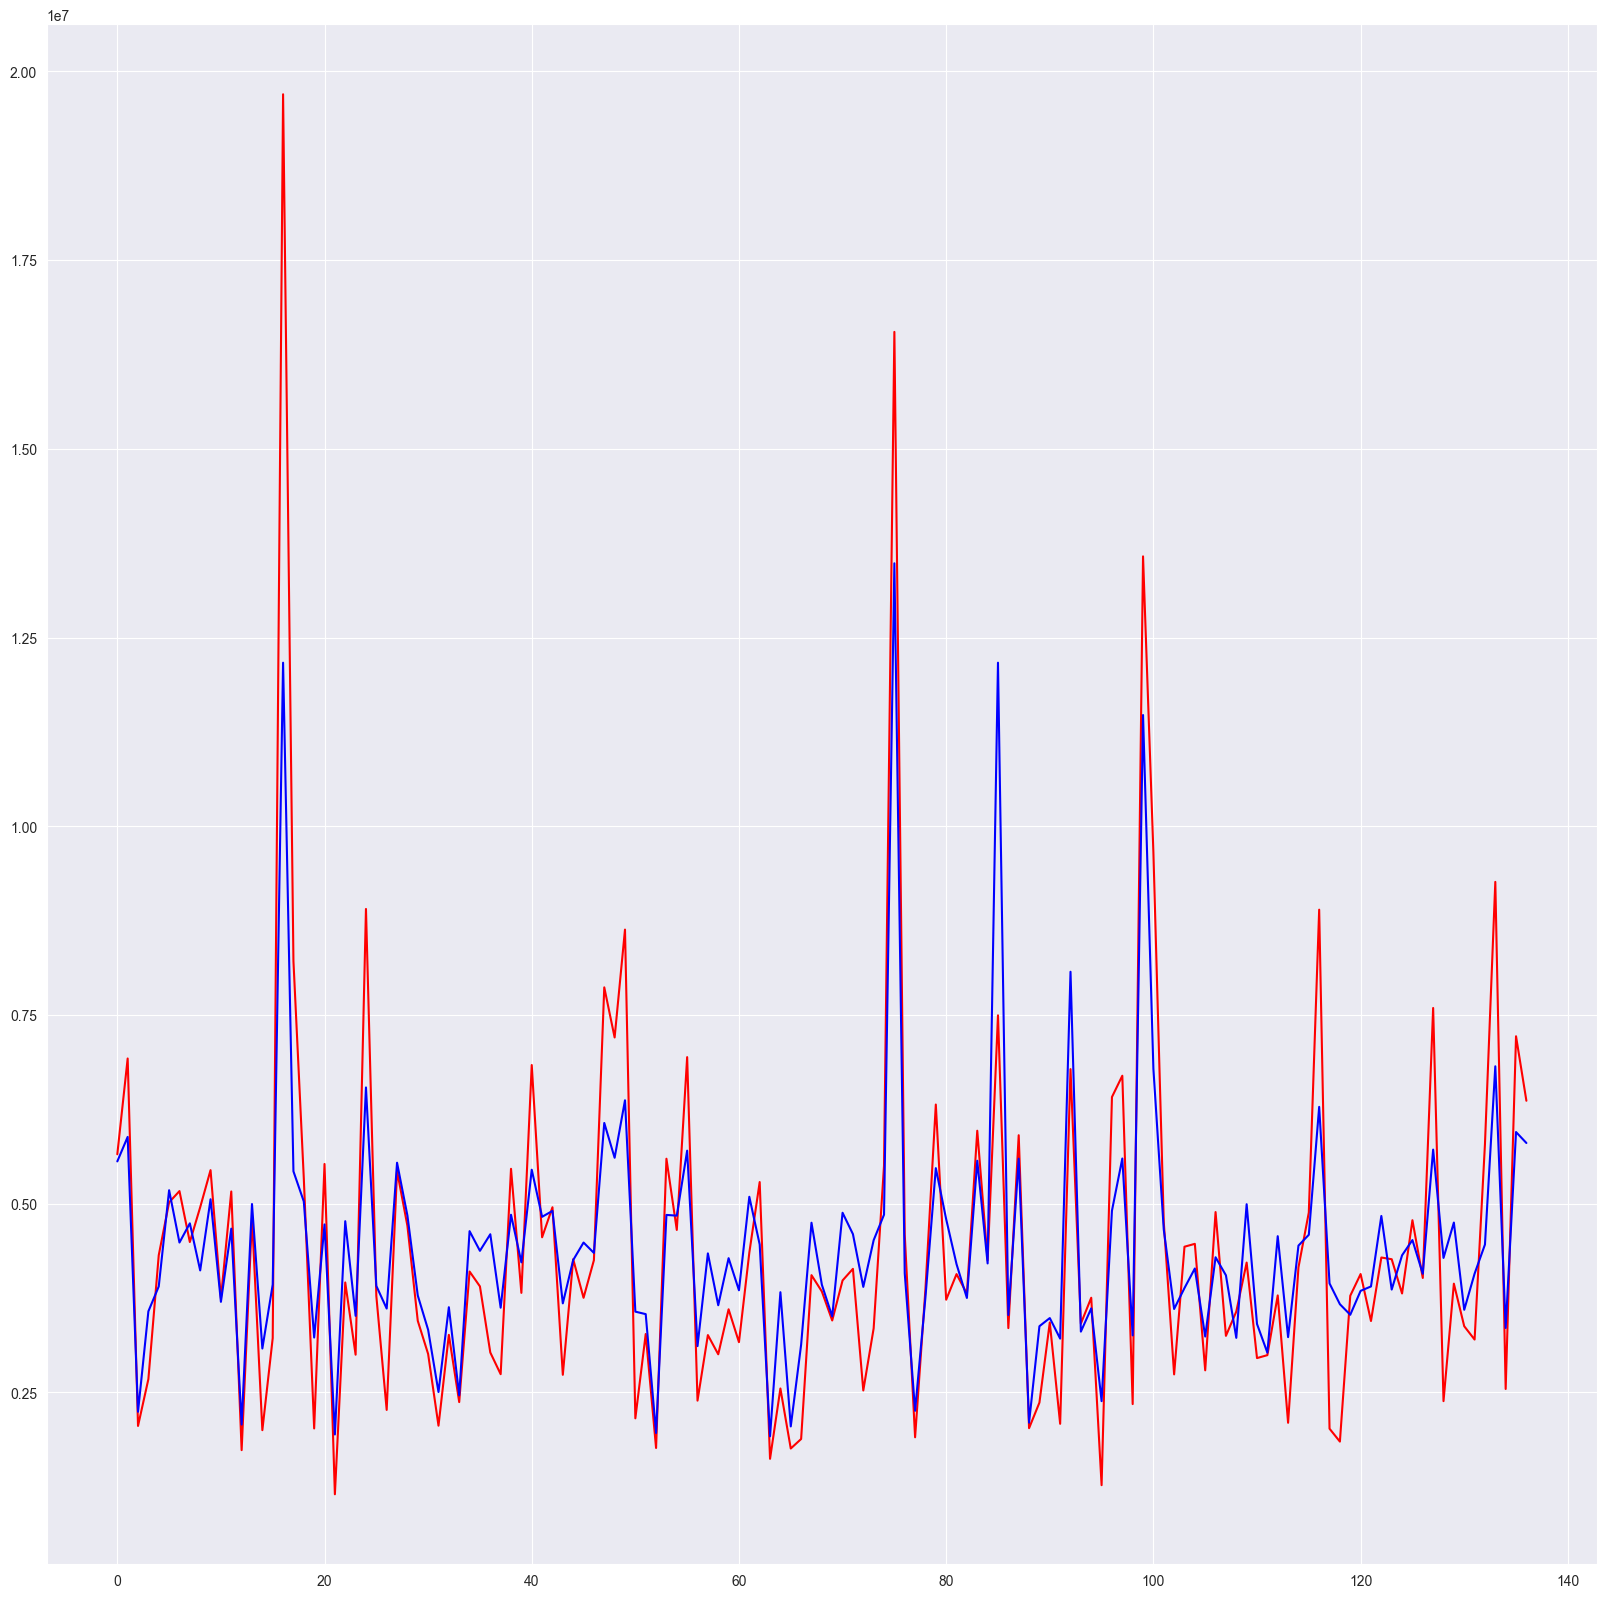

In [645]:
plt.figure(figsize=(20, 20))
plt.plot(Y, "red", y_predict, "blue")
plt.show()